# Problem 1

(a) Express $f_t$ in terms of $K$ and $F_t$ and a discount factor.

$$\begin{aligned}
    S_{T_2}-F_t &= S_0 - e^{-r (T_2-t)} F_t\\
    F_t &= e^{r (T_2-t)} S_0 \\
    S_{T_2}-K &= S_{T_2}-F_t+F_t-K = S_0 - e^{-r (T_2-t)} (F_t - F_t + K) \\
    S_{T_2}-K - S_{T_2}+F_t &= e^{-r (T_2-t)} (F_t-K) = f_t
\end{aligned}$$

(b) Explain briefly (one or two sentences, no math) why this specific arbitrage does not apply to crude oil, by specifically pinpointing, in the quote above, why we cannot simply replace “stock” with “crude oil”.

The transfer of ownership of stock is digital whereas the transfer of crude oil is physical. Even if the oil is not delivered, the warehousing of the purchased position incurs non-zero cost.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
from math import comb

In [2]:
class Dynamics:
    pass

In [3]:
hw5dynamics=Dynamics()
hw5dynamics.kappa = 0.472
hw5dynamics.alpha = 4.4
hw5dynamics.sigma = 0.368
hw5dynamics.S0 = 106.9
hw5dynamics.r = 0.05

In [4]:
class Contract:
    pass

In [5]:
hw5contract=Contract()
hw5contract.K1 = 103.2
hw5contract.T1 = 0.5
hw5contract.T2 = 0.75

In [6]:
class MC:
    pass

In [7]:
hw5MC=MC()
hw5MC.N = 100   # Number of timesteps on each path
hw5MC.M = int(1e5)  # Number of paths.  Change this if necessary.
hw5MC.epsilon = 0.01  # For the dC/dS calculation
hw5MC.seed = 0  # Seeding the random number generator with a specified number helps make the calculations reproducible

(c) Estimate C(S0) using Monte Carlo simulation.

(d) Estimate Call Delta.

In [8]:
def pricer_oilcall_OU_MC(contract,dynamics,MC):
    K1, T1, T2 = contract.K1, contract.T1, contract.T2
    kappa, alpha, sigma = dynamics.kappa, dynamics.alpha, dynamics.sigma
    S0, r = dynamics.S0, dynamics.r
    N, M, epsilon = MC.N, MC.M, MC.epsilon
    
    deltat = T1 / N
    instsig = sigma*np.sqrt(deltat)

    np.random.seed(MC.seed)  #seed the random number generator
    
    # You complete the coding of this function
    X = np.zeros((M, N+1)) # allocate memory for MC Grid
    X[:,0] = np.ones(M)*np.log(S0) # initial condition
    X_up = np.zeros((M, N+1))
    X_up[:,0] = np.ones(M)*np.log(S0+epsilon)
    
    # Walk through the Monte Carlo
    for i in range(N):
        dW = np.random.randn(M)
        X_t = X[:,i]
        X[:,i+1] = X_t + kappa*(alpha-X_t)*deltat + instsig*dW
        X_t = X_up[:,i]
        X_up[:,i+1] = X_t + kappa*(alpha-X_t)*deltat + instsig*dW
    
    S = np.exp(X)
    t = np.linspace(0, T1, N+1)
    disc = np.exp(-kappa * (T2-t))
    F = np.exp(disc*X + (1-disc)*alpha + sigma**2/(4*kappa)*(1-disc**2))
    C = np.exp(-r*T1) * np.maximum(F[:,-1] - K1, 0)
    call_price = np.mean(C)
    standard_error = np.std(C, ddof=1) / np.sqrt(M)
    
    F_up = np.exp(disc*X_up + (1-disc)*alpha + sigma**2/(4*kappa)*(1-disc**2))
    C_up = np.exp(-r*T1) * np.maximum(F_up[:,-1] - K1, 0)
    call_delta = (np.mean(C_up) - call_price) / epsilon
    
    return(call_price, standard_error, call_delta, F, F_up)#, X, C, S)
        

In [9]:
(call_price, standard_error, call_delta, F, F_up) = pricer_oilcall_OU_MC(hw5contract,hw5dynamics,hw5MC)
# , X, C, F

In [10]:
print(call_price, standard_error, call_delta)

7.800302060834111 0.04220796797933716 0.3428634665759489


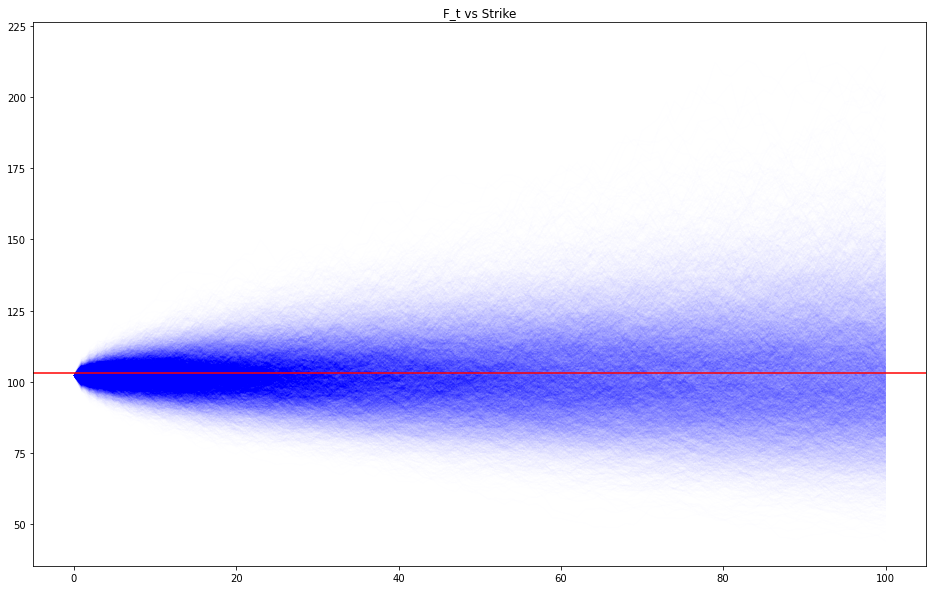

In [11]:
fig, ax = plt.subplots()

F_t = pd.DataFrame(F.T)
to_plot = F_t.iloc[:,:10000]
to_plot.plot(color='b', alpha=0.002, ax=ax)
ax.get_legend().remove()
ax.axhline(hw5contract.K1, color='r', label="Strike")
plt.title("F_t vs Strike")
plt.show()

(e) Analytically calculate Delta

$$\begin{aligned}
    f_t &= e^{-r (T_2-t)} (F_t-K) \\
    F_t &= exp \bigg[ e^{-\kappa (T_2-t)} \log S_t + (1-e^{-\kappa (T_2-t)})\alpha + \frac{\sigma^2}{4\kappa} (1-e^{-2\kappa (T_2-t)}) \bigg] \\
    &= S_t^{e^{-\kappa (T_2-t)} } exp \bigg[ (1-e^{-\kappa (T_2-t)})\alpha + \frac{\sigma^2}{4\kappa} (1-e^{-2\kappa (T_2-t)}) \bigg] \\
    \frac{\partial F_0}{\partial S} &= e^{-\kappa (T_2-t)} S_t^{e^{-\kappa (T_2-t)} -1} exp \bigg[ (1-e^{-\kappa (T_2-t)})\alpha + \frac{\sigma^2}{4\kappa} (1-e^{-2\kappa (T_2-t)}) \bigg] \\
    \frac{\partial f_0}{\partial S} &= e^{-r (T_2)} \frac{\partial F_0}{\partial S} \\
    &= e^{-r (T_2)-\kappa (T_2)} S_0^{e^{-\kappa (T_2)} -1} exp \bigg[ (1-e^{-\kappa (T_2)})\alpha + \frac{\sigma^2}{4\kappa} (1-e^{-2\kappa (T_2)}) \bigg] \\
    &= S_0^{e^{-\kappa (T_2)} -1} exp \bigg[ T_2 (-r-\kappa) + (1-e^{-\kappa (T_2)})\alpha + \frac{\sigma^2}{4\kappa} (1-e^{-2\kappa (T_2)}) \bigg] \\
\end{aligned}$$

In [12]:
T2 = hw5contract.T2
kappa, alpha, sigma = hw5dynamics.kappa, hw5dynamics.alpha, hw5dynamics.sigma
S0, r = hw5dynamics.S0, hw5dynamics.r

fdelta = ( S0**(np.exp(-kappa*T2)-1) * np.exp(T2 * (-r-kappa)
          + (1-np.exp(-kappa*T2))*alpha + sigma**2/(4*kappa)
          *(1-np.exp(-2*kappa*T2))) )
print(fdelta)

0.6465109164314246


(f) Delta Hedge $-C(S_0)$ using n units of $f_0$

In [13]:
print(call_delta/fdelta)

0.5303289671711466


(g) Price the purchase agreement.

The purchase agreement is $4000f_0 + 1000C(S_0)$ 

In [14]:
T1 = hw5contract.T1
K = hw5contract.K1

F_0 = np.exp( np.exp(-kappa*(T2))*np.log(S0) + (1-np.exp(-kappa*(T2)))*alpha 
             + sigma**2/(4*kappa)*(1-np.exp(-2*kappa*(T2))) )
f_0 = np.exp(-r*(T2)) * (F_0-K)

purchase_agreement = 4000*f_0 + 1000*call_price
print(purchase_agreement)

4064.4649102163867


# Problem 2

(a) Find the expectation and standard deviation of the fraction of the pot that Patrik will collect, when the last card (the “river”) is dealt in the usual way.

$$\begin{aligned}
    \mathbb{E}[P] &= \frac{34}{44} = 0.7727 \\
    Var[P] &= \mathbb{E}[P^2] - \mathbb{E}[P]^2 \\
    &= \frac{34}{44} - \bigg(\frac{34}{44}\bigg)^2 = \frac{340}{1936} = 0.1756 \\
    Std[P] &= 0.4191
\end{aligned}$$

(b) With replacement.

$$\begin{aligned}
    \mathbb{E}[P_i] &= \frac{1}{3}\frac{34}{44} = 0.2576 \\
    Var[P_i] &= \mathbb{E}[P_i^2] - \mathbb{E}[P_i]^2 \\
    &= \frac{1}{9}\frac{34}{44} - \bigg(\frac{1}{3}\frac{34}{44}\bigg)^2 = \frac{1}{9}\frac{340}{1936} = 0.0195 \\
    Std[P_i] &= 0.1397 \\
    \mathbb{E}[3P_i] &= 3\mathbb{E}[P_i] = 0.7727 \\
    Var[3P_i] &= 3Var[P_i] = 0.0585 \\
    Std[3P_i] &= \sqrt{Var[3P_i]} = 0.2420
\end{aligned}$$

(c) Without replacement.

$$\begin{aligned}
    \mathbb{E}[P] &= \sum_{i=0}^3 \frac{\binom{34}{i}\binom{10}{3-i}}{\binom{44}{3}} \frac{i}{3} = 0.7727 \\
    Var[P] &= \sum_{i=0}^3 \frac{\binom{34}{i}\binom{10}{3-i}}{\binom{44}{3}} \bigg( \frac{i}{3} - \mathbb{E}[P] \bigg)^2 \\
    Std[P] &= \sqrt{Var[P]} = 0.2363
\end{aligned}$$

The standard deviation of the run with replacement is higher than that of the run without replacement. The reduction in standard deviation is accounted for by the fact that each player's win makes it more probable for the opponent to win.

In [15]:
E = 0
for i in range(4):
    E += comb(34,i)*comb(10,3-i)/comb(44,3) * i/3
print(E)

0.7727272727272727


In [16]:
Var = 0
for i in range(4):
    Var += comb(34,i)*comb(10,3-i)/comb(44,3) * (i/3-E)**2
print(Var**0.5)

0.23625654862570683
